In [1]:
from collections import OrderedDict

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def load_predictions(path, n=5, average=True):
    preds = pd.DataFrame()
    for i in range(n):
        preds = preds.append(pd.read_csv(path.format(i), index_col=0))
    if average:
        preds = preds.groupby(level=0).mean()    
    return preds

In [13]:
ls ../results/features/rf/pathological/without_age_and_gender/cv/

config.json                    performances_train.csv  predictions_valid.csv
exp.pkl                        performances_valid.csv
feature_importances_valid.csv  predictions_train.csv


In [9]:
[len(load_predictions("../results/networks/tcn/pathological/cv/predictions_test_{}.csv", average=False, n=i)) for i in range(1,6)]

[544, 1088, 1631, 2174, 2717]

In [15]:
df = pd.read_csv("../results/features/rf/pathological/without_age_and_gender/cv/predictions_valid.csv", index_col=0)
[len(df[df.id <= i]) for i in range(5)]

[544, 1087, 1630, 2173, 2716]

unequal number of predicted examples in cv due to additional preprocessing for feature pipeline..

In [16]:
# drop predictions for reocrding 822 for ensembling, since it was also dropped in the feature pipeline to 
def drop_recording(predictions, rec_id=822):
    predictions = predictions.reset_index(drop=True)
    predictions = predictions.drop(rec_id)
    predictions = predictions.reset_index(drop=True)
    return predictions

In [19]:
def load_network_eval_results(path):
    preds = load_predictions(path, average=True)
    y_true = preds["true_pathological"]
    labels = preds["non-pathological"] <= preds["pathological"]
    preds = preds[["non-pathological", "pathological"]]
    return preds.values, labels.values, y_true.values

In [20]:
def load_network_cv_results(path, drop_rec_id=None):
    preds = load_predictions(path, average=False)
    if drop_rec_id is not None:
        preds = drop_recording(preds, drop_rec_id)
    y_true = preds["true_pathological"]
    labels = preds["non-pathological"] <= preds["pathological"]
    preds = preds[["non-pathological", "pathological"]]
    return preds.values, labels.values, y_true.values

load average over runs of final eval predictions but individual cv run predictions

In [ ]:
deep_eval_preds, deep_eval_labels, deep_eval_y_true = load_network_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/networks/deep/pathological/eval/predictions_test_{}.csv")

In [22]:
deep_cv_preds, deep_cv_labels, deep_cv_y_true = load_network_cv_results(
    path="/home/gemeinl/results/all_recs_100_hz/networks/deep/pathological/cv/predictions_test_{}.csv",
    drop_rec_id=822)

In [23]:
shallow_eval_preds, shallow_eval_labels, shallow_eval_y_true = load_network_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/networks/shallow/pathological/eval/predictions_test_{}.csv")

In [24]:
shallow_cv_preds, shallow_cv_labels, shallow_cv_y_true = load_network_cv_results(
    path="/home/gemeinl/results/all_recs_100_hz/networks/shallow/pathological/cv/predictions_test_{}.csv",
    drop_rec_id=822)

In [25]:
tcn_eval_preds, tcn_eval_labels, tcn_eval_y_true = load_network_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/networks/tcn/pathological/eval/predictions_test_{}.csv")

In [26]:
tcn_cv_preds, tcn_cv_labels, tcn_cv_y_true = load_network_cv_results(
    path="/home/gemeinl/results/all_recs_100_hz/networks/tcn/pathological/cv/predictions_test_{}.csv",
    drop_rec_id=822)

In [27]:
eegnet_eval_preds, eegnet_eval_labels, eegnet_eval_y_true = load_network_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/networks/eegnet/pathological/eval/predictions_test_{}.csv")

In [28]:
eegnet_cv_preds, eegnet_cv_labels, eegnet_cv_y_true = load_network_cv_results(
    path="/home/gemeinl/results/all_recs_100_hz/networks/eegnet/pathological/cv/predictions_test_{}.csv",
    drop_rec_id=822)

In [29]:
assert len(deep_cv_preds) == len(shallow_cv_preds) == len(tcn_cv_preds) == len(eegnet_cv_preds)

In [30]:
assert ((deep_cv_y_true * shallow_cv_y_true * tcn_cv_y_true * eegnet_cv_y_true) == deep_cv_y_true).sum() == len(deep_cv_y_true)
assert ((deep_eval_y_true * shallow_eval_y_true * tcn_eval_y_true * eegnet_eval_y_true) == deep_eval_y_true).sum() == len(deep_eval_y_true)

In [31]:
def load_feature_eval_results(path, average=True, thresh=.5):
    preds = pd.read_csv(path, index_col=0)
    if average:
        preds = preds.groupby("group").mean()
    preds = preds.reset_index(drop=True)
    y_true = preds["y_true"]
    labels = preds["y_pred"] >= thresh
    preds = pd.DataFrame(np.concatenate([1-preds["y_pred"].values.reshape(-1, 1), 
                                         preds["y_pred"].values.reshape(-1, 1)], axis=1),
                         columns=["non-pathological", "pathological"])
    return preds.values, labels.values, y_true.values

In [32]:
rf_eval_preds, rf_eval_labels, rf_eval_y_true = load_feature_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/features/rf/pathological/without_age_and_gender/eval/predictions_eval.csv",
    average=True
)

In [33]:
rf_cv_preds, rf_cv_labels, rf_cv_y_true = load_feature_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/features/rf/pathological/without_age_and_gender/cv/predictions_valid.csv", 
    average=False)

In [34]:
svm_eval_preds, svm_eval_labels, svm_eval_y_true = load_feature_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/features/svm/pathological/without_age_and_gender/eval/predictions_eval.csv")

In [35]:
svm_cv_preds, svm_cv_labels, svm_cv_y_true = load_feature_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/features/svm/pathological/without_age_and_gender/cv/predictions_valid.csv", 
    average=False)

In [36]:
asc_eval_preds = pd.read_csv("/home/gemeinl/results/all_recs_100_hz/features/asc/pathological/probas_eval.csv", index_col=0)
asc_eval_labels = asc_eval_preds["1"] >= .5
asc_eval_preds = pd.DataFrame(np.concatenate([asc_eval_preds["1"].values.reshape(-1, 1), 
                                              1-asc_eval_preds["1"].values.reshape(-1, 1)], axis=1), 
                              columns=["pathological", "non-pathological"])

auto-sklearn classifier does not give access to cv predictions. cv is handled internally

In [26]:
# there are no cv predictions for auto-sklearn. it does not give access
#asc_cv_preds = pd.read_csv("/home/gemeinl/results/all_recs_100_hz/features/asc/pathological/probas_valid.csv", index_col=0).groupby("group").mean()
#asc_cv_y_true = asc_cv_preds["y_true"]
#asc_cv_labels = asc_cv_preds["y_pred"] >= .5
#asc_cv_preds = pd.DataFrame(np.concatenate([asc_cv_preds["y_pred"].values.reshape(-1, 1), 
#                                            1-asc_cv_preds["y_pred"].values.reshape(-1, 1)], axis=1), 
#                            columns=["pathological", "non-pathological"])

In [27]:
riemannian_eval_preds, riemannian_eval_labels, riemannian_eval_y_true = load_feature_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/features/riemannian/pathological/eval/predictions_eval.csv",
    average=False)
#riemannian_eval_preds = np.repeat(riemannian_eval_preds, 5, axis=0)
#riemannian_eval_labels = np.tile(riemannian_eval_labels, 5)
#riemannian_eval_y_true = np.tile(riemannian_eval_y_true, 5,)

In [28]:
riemannian_cv_preds, riemannian_cv_labels, riemannian_cv_y_true = load_feature_eval_results(
    path="/home/gemeinl/results/all_recs_100_hz/features/riemannian/pathological/cv/predictions_valid.csv", 
    average=False)

In [29]:
assert len(rf_cv_preds) == len(svm_cv_preds) == len(riemannian_cv_preds)
assert len(rf_eval_preds) == len(svm_eval_preds) == len(riemannian_eval_preds)

In [30]:
assert ((rf_cv_y_true * svm_cv_y_true * riemannian_cv_y_true) == rf_cv_y_true).sum() == len(rf_cv_y_true)
assert ((rf_eval_y_true * svm_eval_y_true * riemannian_eval_y_true) == rf_eval_y_true).sum() == len(rf_eval_y_true)

In [31]:
# check that network and feature ground truths are the same
assert (rf_cv_y_true == deep_cv_y_true).sum() == len(deep_cv_y_true)
assert (rf_eval_y_true == deep_eval_y_true).sum() == len(deep_eval_y_true)

In [32]:
for ix, l in enumerate(deep_eval_y_true):
    assert rf_eval_y_true[ix] == l

In [33]:
cv_y_true = deep_cv_y_true
eval_y_true = deep_eval_y_true

In [34]:
cv_preds_dict = OrderedDict({
    "BD-Deep4": deep_cv_preds,
    "BD-Shallow": shallow_cv_preds, 
    "BD-TCN": tcn_cv_preds,
    "BD-EEGNet": eegnet_cv_preds,
    "RF": rf_cv_preds, 
    "SVM": svm_cv_preds,
    "RG": riemannian_cv_preds
})

In [35]:
cv_labels_dict = OrderedDict({
    "BD-Deep4": deep_cv_labels,
    "BD-Shallow": shallow_cv_labels,
    "BD-TCN": tcn_cv_labels, 
    "BD-EEGNet": eegnet_cv_labels,
    "RF": rf_cv_labels,
    "SVM": svm_cv_labels,
    "RG": riemannian_cv_labels
})

In [36]:
eval_preds_dict = OrderedDict({
    "BD-Deep4": deep_eval_preds,
    "BD-Shallow": shallow_eval_preds, 
    "BD-TCN": tcn_eval_preds,
    "BD-EEGNet": eegnet_eval_preds,
    "RF": rf_eval_preds, 
    "SVM": svm_eval_preds,
    "RG": riemannian_eval_preds
})

In [37]:
eval_labels_dict = OrderedDict({
    "BD-Deep4": deep_eval_labels,
    "BD-Shallow": shallow_eval_labels,
    "BD-TCN": tcn_eval_labels, 
    "BD-EEGNet": eegnet_eval_labels,
    "RF": rf_eval_labels,
    "SVM": svm_eval_labels,
    "RG": riemannian_eval_labels
})

In [38]:
from scipy.stats import spearmanr

In [39]:
models = ("BD-Deep4", "BD-Shallow", "BD-TCN", "BD-EEGNet", "RF", "SVM", "RG")

In [40]:
cs = np.zeros((len(models), len(models)))

for i, m1 in enumerate(models):
    for j in range(0, i):
        m2 = models[j]
        c, p =spearmanr(cv_preds_dict[m1][:,1], cv_preds_dict[m2][:,1])
        cs[i,j] = c
        m1_errors = (cv_labels_dict[m1] != cv_y_true)
        m2_errors = (cv_labels_dict[m2] != cv_y_true)
        e = (m1_errors != m2_errors).sum()/len(set(list(np.arange(len(m1_errors))[m2_errors]) + list(np.arange(len(m1_errors))[m1_errors])))        
        cs[j,i]=e

In [46]:
m1_errors = (cv_labels_dict["BD-Deep4"] != cv_y_true)
m2_errors = (cv_labels_dict["RG"] != cv_y_true)

In [47]:
m1_errors.sum(), m2_errors.sum()

(415, 509)

In [48]:
# overlapping label errors
len(set(list(np.arange(len(m1_errors))[m2_errors]) + list(np.arange(len(m1_errors))[m1_errors])))

664

In [49]:
# non-overlapping label errors
(m1_errors != m2_errors).sum()/len(set(list(np.arange(len(m1_errors))[m2_errors]) + list(np.arange(len(m1_errors))[m1_errors])))

0.608433734939759

In [50]:
(deep_cv_y_true == deep_cv_labels).mean()

0.8472017673048601

In [51]:
(deep_cv_y_true == rf_cv_labels).mean()

0.8310014727540501

In [52]:
(deep_cv_y_true == cv_y_true).mean()

1.0

In [53]:
(deep_cv_labels == cv_y_true).mean()

0.8472017673048601

In [54]:
(cv_y_true == rf_cv_labels).mean()

0.8310014727540501

In [55]:
import matplotlib
fs = 16
matplotlib.rcParams.update({'font.size': fs})

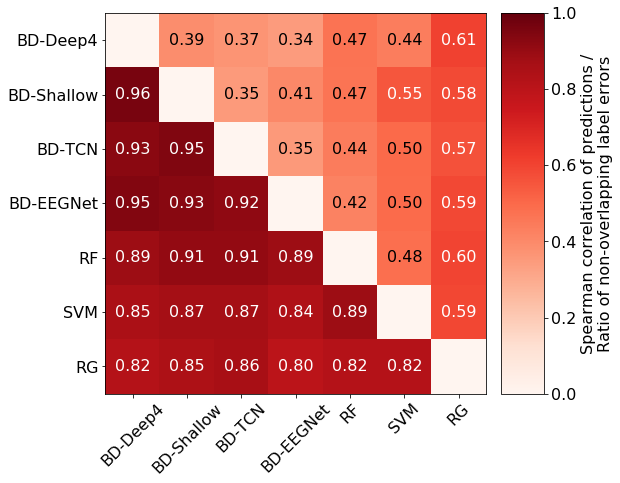

In [56]:
fig, ax = plt.subplots(figsize=(12,7))
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45)
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
im = ax.imshow(cs, cmap="Reds", origin="upper")
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([0.85, 0.125, 0.05, 0.755])
cbar = fig.colorbar(im, cax=cbar_ax)
im.set_clim([0,1])
cbar.ax.set_ylabel("Spearman correlation of predictions /\nRatio of non-overlapping label errors");

for i in range(len(models)):
    for j in range(0, i):
        c = "k" if cs[i][j] < .5 else "w"
        ax.text(j, i, "{:.2f}".format(cs[i,j]), va="center", ha="center", color=c)
        c = "k" if cs[j][i] < .5 else "w"
        ax.text(i, j, "{:.2f}".format(cs[j,i]), va="center", ha="center", color=c)

fig.savefig("/home/gemeinl/prediction_correlation_with_ratio_of_uncorrelated_errors.pdf", bbox_inches="tight")

__try ensembling based on majority vote__

In [52]:
from itertools import combinations

In [53]:
# build all possible odd numbered ensembles and create majority vote ensemble labels for cross validation
df = pd.DataFrame()
for ensemble_size in (range(3, len(cv_labels_dict)+1, 2)):
    for ensemble in combinations(cv_labels_dict.keys(), ensemble_size):
        ensemble_labels = [cv_labels_dict[m] for m in ensemble]
        acc = ((np.sum(ensemble_labels, axis=0) >= int(ensemble_size/2)+1) == cv_y_true).mean()
        d = {"Model {}".format(i+1): m for i, m in enumerate(ensemble)}
        d.update({"accuracy": acc})
        df = df.append(d, ignore_index=True)

In [54]:
df.sort_values("accuracy", ascending=False).head(10)

,Model 1,Model 2,Model 3,accuracy,Model 4,Model 5,Model 6,Model 7
0,Deep,Shallow,TCN,0.857511,NaN,NaN,NaN,NaN
17,Shallow,TCN,SVM,0.857143,NaN,NaN,NaN,NaN
16,Shallow,TCN,RF,0.856775,NaN,NaN,NaN,NaN
6,Deep,TCN,RF,0.856406,NaN,NaN,NaN,NaN
8,Deep,TCN,RG,0.856038,NaN,NaN,NaN,NaN
39,Deep,Shallow,TCN,0.855670,RF,RG,NaN,NaN
2,Deep,Shallow,RF,0.855670,NaN,NaN,NaN,NaN
38,Deep,Shallow,TCN,0.855670,RF,SVM,NaN,NaN
15,Shallow,TCN,EEGNet,0.854934,NaN,NaN,NaN,NaN
40,Deep,Shallow,TCN,0.854197,SVM,RG,NaN,NaN


best cv result is 85.75%. so far best was TCN with 85.76% -> no improvement

In [55]:
# use best majority vote cv ensemble for final evaluation
ensemble = ["Deep", "Shallow", "TCN"]
ensemble_labels = [eval_labels_dict[m] for m in ensemble]
acc = ((np.sum(ensemble_labels, axis=0) >= int(len(ensemble)/2)+1) == eval_y_true).mean()

In [56]:
acc

0.855072463768116

In [57]:
# use first majority vote cv ensemble with RG and TCN (top5)
ensemble = ["Deep", "TCN", "RG"]
ensemble_labels = [eval_labels_dict[m] for m in ensemble]
acc = ((np.sum(ensemble_labels, axis=0) >= int(len(ensemble)/2)+1) == eval_y_true).mean()

In [58]:
acc

0.8695652173913043

In [59]:
# use best 5-model majority vote cv ensemble
ensemble = ["RF", "Deep", "Shallow", "TCN", "RG"]
ensemble_labels = [eval_labels_dict[m] for m in ensemble]
acc = ((np.sum(ensemble_labels, axis=0) >= int(len(ensemble)/2)+1) == eval_y_true).mean()

In [60]:
acc

0.8586956521739131

-> majority voting of ensemble labels can increase accuracy to 86.96% in final evaluation

-> best single-model is TCN with 86.16%

__now lets do it right. choose the 3 models that have most non-overlapping label errors__

In [62]:
def error_ids(errors):
    return np.arange(len(errors))[errors]

In [63]:
df = pd.DataFrame()
for i in range(len(models)):
    m1 = models[i]
    for j in range(i+1, len(models)):
        m2 = models[j]
        for k in range(j+1, len(models)):
            m3 = models[k]
            #print(i, m1, j, m2, k, m3)
            m1_errors = cv_labels_dict[m1] != cv_y_true
            m2_errors = cv_labels_dict[m2] != cv_y_true
            m3_errors = cv_labels_dict[m3] != cv_y_true  
            
            e0, e1, e2, e3 = np.bincount(np.bincount(
                list(error_ids(m1_errors)) +
                list(error_ids(m2_errors)) + 
                list(error_ids(m3_errors))
            ))
            d = {"Model 1": m1, "Model 2": m2, "Model 3": m3, "E0":len(cv_y_true)-e1-e2-e3, "E1": e1, "E2": e2, "E3": e3, "E1 Ratio [%]": e1/(e1+e2+e3) * 100}
            df = df.append(d, ignore_index=True)

import sys

sys.path.insert(1, "/home/gemeinl/code/cropped_decoding/")

from cropped_decoding.utils import set_df_column_dtypes

pd.options.display.float_format = '{:,.2f}'.format

print(set_df_column_dtypes(df[["Model 1", "Model 2", "Model 3", "E0", "E1", "E2", "E3", "E1 Ratio [%]"]], [str, str, str, int, int, int, int, float]).to_latex())

In [85]:
df.sort_values("E1 Ratio [%]", ascending=False)

,E0,E1,E1 Ratio [%],E2,E3,Model 1,Model 2,Model 3
13,1962.0,336.0,44.562334,207.0,211.0,Deep,RF,RG
24,1935.0,343.0,43.918054,233.0,205.0,Shallow,SVM,RG
30,1962.0,331.0,43.899204,204.0,219.0,TCN,SVM,RG
33,1925.0,346.0,43.742099,221.0,224.0,EEGNet,SVM,RG
8,2021.0,304.0,43.741007,166.0,225.0,Deep,TCN,RG
23,1970.0,325.0,43.565684,205.0,216.0,Shallow,RF,RG
29,1992.0,313.0,43.232044,191.0,220.0,TCN,RF,RG
27,2010.0,305.0,43.201133,161.0,240.0,TCN,EEGNet,RG
11,1990.0,312.0,42.975207,179.0,235.0,Deep,EEGNet,RG
34,1924.0,337.0,42.550505,234.0,221.0,RF,SVM,RG


In [86]:
e0, e1, e2, e3 = np.bincount(np.bincount(list(error_ids(m1_errors)) + list(error_ids(m2_errors)) + list(error_ids(m3_errors))))

In [87]:
print("not misclassified by a single model: {}".format(len(cv_y_true)-e1-e2-e3))

not misclassified by a single model: 1924


In [88]:
print("misclassified by a single model: {}".format(e1))

misclassified by a single model: 337


In [89]:
print("misclassified by two models: {}".format(e2))

misclassified by two models: 234


In [90]:
print("misclassified by three models: {}".format(e3))

misclassified by three models: 221


In [91]:
print("misclassified by at least one model: {}".format(e1+e2+e3))

misclassified by at least one model: 792


In [92]:
# use 3 model combination that has highest e1 errors
ensemble = ["Deep", "RF", "RG"]
ensemble_labels = [cv_labels_dict[m] for m in ensemble]
acc = ((np.sum(ensemble_labels, axis=0) >= int(len(ensemble)/2)+1) == cv_y_true).mean()

In [93]:
acc

0.8460972017673049

In [94]:
# use best majority vote cv ensemble for final evaluation
ensemble = ["Deep", "RF", "RG"]
ensemble_labels = [eval_labels_dict[m] for m in ensemble]
acc = ((np.sum(ensemble_labels, axis=0) >= int(len(ensemble)/2)+1) == eval_y_true).mean()

In [95]:
acc

0.855072463768116

__lets try autosklearn for ensemble selection__

In [70]:
import sys

In [71]:
sys.path.insert(1, "/home/gemeinl/code/auto-sklearn/")

In [72]:
import autosklearn

In [73]:
autosklearn.__version__

'0.6.0'

In [82]:
from autosklearn.ensemble_builder import EnsembleSelection
from autosklearn.metrics import accuracy
from autosklearn.constants import BINARY_CLASSIFICATION

search over different ensemble sizes

In [83]:
df = pd.DataFrame()
for ensemble_size in range(2, 50):
    selector = EnsembleSelection(
        ensemble_size=ensemble_size,
        metric=accuracy,
        task_type=BINARY_CLASSIFICATION,
        random_state=np.random.RandomState((2019, 8, 22))
    )
    selector = selector.fit(
        predictions=np.array([cv_preds_dict[key] for key in sorted(list(cv_preds_dict.keys()))]),
        labels=cv_y_true,
        identifiers=sorted(list(cv_preds_dict.keys()))
    )
    ensemble_predictions = selector.predict(predictions)    
    ensemble_weights_and_models = selector.get_models_with_weights({key: key for key in cv_preds_dict.keys()})
    ensemble_eval_preds = np.sum([eval_preds_dict[model] * weight for weight, model in ensemble_weights_and_models], axis=0)
    
    d = {m: w for w, m in ensemble_weights_and_models}
    d["cv_accuracy"] = 1 - selector.get_validation_performance()
    d["ensemble_size"] = ensemble_size
    df = df.append(d, ignore_index=True)

In [84]:
df.sort_values("cv_accuracy", ascending=False).head(5)

,RF,TCN,cv_accuracy,ensemble_size,Shallow,EEGNet,Deep,RG
19,0.190476,0.190476,0.862297,21.0,0.285714,0.238095,0.047619,0.047619
20,0.227273,0.181818,0.861929,22.0,0.272727,0.227273,0.045455,0.045455
42,0.250000,0.227273,0.861929,44.0,0.250000,0.159091,0.090909,0.022727
40,0.238095,0.214286,0.861929,42.0,0.261905,0.166667,0.095238,0.023810
39,0.243902,0.219512,0.861929,41.0,0.243902,0.170732,0.097561,0.024390


TCN CV is 85.76% -> some improvement

In [85]:
# rebuild the best cv ensemble from above
selector = EnsembleSelection(
    ensemble_size=df.sort_values("cv_accuracy", ascending=False).head(1)["ensemble_size"],
    metric=accuracy,
    task_type=BINARY_CLASSIFICATION,
    random_state=np.random.RandomState((2019, 8, 22))
)
selector = selector.fit(
    predictions=np.array([cv_preds_dict[key] for key in sorted(list(cv_preds_dict.keys()))]),
    labels=cv_y_true,
    identifiers=identifiers
)
ensemble_predictions = selector.predict(np.array([cv_preds_dict[key] for key in sorted(list(cv_preds_dict.keys()))]))    
ensemble_weights_and_models = selector.get_models_with_weights({key: key for key in cv_preds_dict.keys()})
ensemble_weights_and_models

[(0.28571428571428575, 'Shallow'),
 (0.2380952380952381, 'EEGNet'),
 (0.1904761904761905, 'RF'),
 (0.1904761904761905, 'TCN'),
 (0.04761904761904762, 'Deep'),
 (0.04761904761904762, 'RG')]

In [86]:
# re-check cv accuracy
((ensemble_predictions[:, 1] >= ensemble_predictions[:, 0]) == cv_y_true).mean()

0.8622974963181149

In [89]:
# compute final evaluation ensemble accuracy
ensemble_final_eval_predictions = []
for w, m in ensemble_weights_and_models:
    ensemble_final_eval_predictions.append(w * eval_preds_dict[m])
ensemble_final_eval_predictions = np.sum(ensemble_final_eval_predictions, axis=0)

In [90]:
((ensemble_final_eval_predictions[:, 1] >= ensemble_final_eval_predictions[:, 0]) == eval_y_true).mean()

0.8514492753623188

-> no increase in final evaluation accuracy

out of curiosity: check how good an ensemble can get on every cv fold

In [91]:
from sklearn.model_selection import KFold

In [92]:
kf = KFold(n_splits=5, shuffle=False)

In [93]:
ensemble_size = 50
df = pd.DataFrame()
for i, (train_i, test_i) in enumerate(kf.split(np.arange(len(cv_y_true)))):
    fold_predictions = np.array([cv_preds_dict[key] for key in sorted(list(cv_preds_dict.keys()))])[:, test_i, :]
    fold_labels = cv_y_true[test_i]
    
    selector = EnsembleSelection(
        ensemble_size=ensemble_size,
        metric=accuracy,
        task_type=BINARY_CLASSIFICATION,
        random_state=np.random.RandomState((2019, 8, 22))
    )
    selector = selector.fit(
        predictions=fold_predictions,
        labels=fold_labels,
        identifiers=identifiers
    )
    
    ensemble_predictions = selector.predict(fold_predictions)    
    ensemble_weights_and_models = selector.get_models_with_weights({key: key for key in cv_preds_dict.keys()})
    
    d = {m: w for w, m in ensemble_weights_and_models}
    d["cv_accuracy"] = 1 - selector.get_validation_performance()
    d["ensemble_size"] = ensemble_size
    df = df.append(d, ignore_index=True)

In [94]:
df.sort_values("cv_accuracy", ascending=False).head(10)

,Deep,RF,Shallow,TCN,cv_accuracy,ensemble_size,EEGNet,RG,SVM
4,0.30,0.10,0.26,0.16,0.887661,50.0,0.16,0.02,NaN
2,NaN,0.36,0.10,0.52,0.883978,50.0,NaN,0.02,NaN
1,NaN,0.30,0.16,0.18,0.876611,50.0,0.02,0.32,0.02
0,0.26,0.32,0.10,0.32,0.862132,50.0,NaN,NaN,NaN
3,0.56,0.16,NaN,0.20,0.847145,50.0,NaN,NaN,0.08
